# Santa Tree Packing Optimization — Kaggle Competition.

_Authour:_ Eugene Maina.

This notebook is structured in CRISP-DM style and implements a fast, competitive solver for the Santa tree packing problem (Kaggle).

**What’s included:**
- Shapely-based geometry and collision checks
- Dense **hex lattice** initializers + rotation patterns
- **Global compression (binary search)** + **anisotropic square-aimed compression**
- Lightweight **polishers** (center pull / axis compaction / micro-rotation)
- **Adaptive schedules** based on number of trees `n`
- End-to-end solver for `n = 1..200`, rho diagnostics, and submission builder


## 0. Notebook Dependencies
If Shapely is missing in your environment, uncomment the install line below.

In [240]:
# Uncomment only if needed
# !pip -q install shapely

import random
from functools import lru_cache
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext

from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
import warnings
warnings.filterwarnings("ignore")

## 1. Business Understanding

 Minimize the average square area per tree by optimally placing and rotating tree shapes inside the smallest possible square, across multiple configurations.

**Success Metric:**

$$ \text{Total Score} = \sum_{puzzles} \frac{s^2}{n} $$

Where:

$s$ = side length of minimal bounding square

$n$ = number of trees in that puzzle

**Hard Constraints:**

- No overlapping trees

- All trees must lie within coordinate bounds

- Output format must follow Kaggle spec

**Optimization Mindset:**

- Feasibility first, tightness second.


## 3. Modelling Assumptions
- Trees are 2D polygons.
- Rotation is allowed (degrees).
- The evaluator uses an **axis-aligned** bounding square.
- Touching edges is allowed; overlapping interiors is not.

⚠️ **Coordinate bounds:** Competition rules constrain x/y to a fixed range. Set `BOUNDS` accordingly.


In [241]:
# Coordinate bounds (UPDATE this to match the competition's metric notebook)
# Keeping a conservative default that works for most Kaggle packing puzzles.
BOUNDS = (-100.0, 100.0)

# Numerical tolerance
EPS = 1e-9

# Hex grid parameters (tuned values)
HEX_BASE_DEG_DEFAULT = np.float64(120.0) # degree
SPACING_SAFETY = 1.02        # or whatever your tuned value is
HEX_DY_MUL = 0.95           # tuned
HEX_ROW_OFFSET_MUL = 0.44559   # tuned around 0.46–0.54 typically

## 4. Geometry Layer
### 4.1 Canonical Tree Polygon
We define one canonical tree polygon at the origin. All placements are transforms of this base shape.

This shape matches the multi-tier tree used in the Kaggle metric Evaluation

Rationale: The base polygon below uses the same parameter set as `example.ipynb` (trunk_w=0.15, trunk_h=0.2, base_w=0.7, mid_w=0.4, top_w=0.25, tip_y=0.8, tier_1_y=0.5, tier_2_y=0.25). We keep `scale_factor=1` to preserve the original coordinate system while matching the shape.


In [290]:
# Decimal precision and scaling factor
getcontext().prec = 25
scale_factor = Decimal('1')

class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        # Geometry parameters match example.ipynb; scale_factor=1 keeps the same coordinate system.

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))


BASE_TREE_POLY = ChristmasTree().polygon
BASE_TREE_POLY.is_valid, BASE_TREE_POLY.area


(True, 0.24562500000000004)

### 4.2 Transform Function
We **rotate about centroid**, then translate by `(x, y)`.

In [291]:


@lru_cache(maxsize=2048)
def _rot_base(deg: float):
    # rounding keeps the cache useful when floats wobble
    deg = float(round(deg, 6))
    return affinity.rotate(BASE_TREE_POLY, deg, origin="centroid", use_radians=False)

def transform_tree(base_polygon, x, y, deg):
    # ignore base_polygon arg if you only ever use BASE_TREE_POLY
    return affinity.translate(_rot_base(deg), xoff=float(x), yoff=float(y))



### 4.3 Stateful Tree Representation
Each tree is stored as a dict:
- `x`, `y`, `deg`
- `poly` (Shapely geometry)

This makes it easy to debug and to generate submissions.

In [292]:
def make_tree_state(x: float, y: float, deg: float, base_polygon: Polygon = BASE_TREE_POLY) -> dict:
    return {
        'x': float(x),
        'y': float(y),
        'deg': float(deg),
        'poly': transform_tree(base_polygon, float(x), float(y), float(deg)),
    }

def rebuild_poly_inplace(t: dict, base_polygon: Polygon = BASE_TREE_POLY) -> None:
    t['poly'] = transform_tree(base_polygon, t['x'], t['y'], t['deg'])

def state_to_polys(state: list[dict]) -> list[Polygon]:
    return [t['poly'] for t in state]

def state_to_layout(state: list[dict]) -> list[tuple[float,float,float]]:
    return [(t['x'], t['y'], t['deg']) for t in state]

def rebuild_state_polys(state: list[dict], base_polygon: Polygon = BASE_TREE_POLY) -> None:
    """
    Rebuild shapely polygons for every tree dict in a state list.
    Matches the notebook's state structure: {'x','y','deg','poly'}.
    """
    for t in state:
        rebuild_poly_inplace(t, base_polygon)

## 5. Feasibility & Metric
### 5.1 Bounds Validation

In [293]:
def in_bounds(x: float, y: float, bounds=BOUNDS) -> bool:
    lo, hi = bounds
    return (lo <= x <= hi) and (lo <= y <= hi)

def validate_bounds_state(state: list[dict], bounds=BOUNDS) -> bool:
    for t in state:
        if not in_bounds(t['x'], t['y'], bounds=bounds):
            return False
    return True


### 5.2 Overlap Checking
We provide:
- A simple `O(n²)` overlap check (good for small n)
- A faster STRtree-based check (good for larger n)
- A local check for a single moved polygon


In [294]:
def overlaps(a: Polygon, b: Polygon) -> bool:
    # touching is allowed
    return a.intersects(b) and (not a.touches(b))

def has_overlap_pairwise(polys: list[Polygon]) -> bool:
    n = len(polys)
    for i in range(n):
        for j in range(i+1, n):
            if overlaps(polys[i], polys[j]):
                return True
    return False

def _strtree_hit_indices(tree: STRtree, geom: Polygon, idx_by_id: dict[int, int]) -> list[int]:
    # STRtree.query returns geometries (shapely<2) or indices (shapely>=2); normalize to indices.
    hits = tree.query(geom)
    if len(hits) == 0:
        return []
    first = hits[0]
    if isinstance(first, (int, np.integer)):
        return [int(i) for i in hits]
    return [idx_by_id[id(h)] for h in hits]

def has_overlap_strtree(polys: list[Polygon]) -> bool:
    if len(polys) < 2:
        return False
    tree = STRtree(polys)
    idx_by_id = {id(g): i for i, g in enumerate(polys)}
    for i, g in enumerate(polys):
        for j in _strtree_hit_indices(tree, g, idx_by_id):
            if j <= i:
                continue
            if overlaps(g, polys[j]):
                return True
    return False

def has_overlap_state(state: list[dict], method: str = 'auto') -> bool:
    polys = state_to_polys(state)
    if method == 'pairwise':
        return has_overlap_pairwise(polys)
    if method == 'strtree':
        return has_overlap_strtree(polys)
    # auto
    return has_overlap_strtree(polys) if len(polys) >= 80 else has_overlap_pairwise(polys)

def poly_overlaps_any(candidate: Polygon, polys: list[Polygon], skip_idx: int) -> bool:
    for j, other in enumerate(polys):
        if j == skip_idx:
            continue
        if overlaps(candidate, other):
            return True
    return False



### 5.3 Bounding Square and Score

In [295]:
# Bounding box and scoring functions
def bounding_square_side_polys(polys: list[Polygon]) -> float:
    if not polys:
        return 0.0
    xmin, ymin, xmax, ymax = polys[0].bounds
    for p in polys[1:]:
        x0, y0, x1, y1 = p.bounds
        xmin = min(xmin, x0)
        ymin = min(ymin, y0)
        xmax = max(xmax, x1)
        ymax = max(ymax, y1)
    width = xmax - xmin
    height = ymax - ymin
    return float(max(width, height))

# Return (s, (xmin,ymin,xmax,ymax)) using polys
def bounding_square_side_state(state: list[dict]):
    """Return (s, (xmin,ymin,xmax,ymax)) using already-built polys in state."""
    xmin = ymin = 1e18
    xmax = ymax = -1e18
    for t in state:
        x0, y0, x1, y1 = t["poly"].bounds
        if x0 < xmin: xmin = x0
        if y0 < ymin: ymin = y0
        if x1 > xmax: xmax = x1
        if y1 > ymax: ymax = y1
    return float(max(xmax - xmin, ymax - ymin)), (xmin, ymin, xmax, ymax)

# Indices of trees that touch the current bbox (active set).
def boundary_indices(state: list[dict], bbox=None, tol: float = 1e-6) -> list[int]:
    """Indices of trees that touch the current bbox (active set)."""
    if bbox is None:
        _, bbox = bounding_square_side_state(state)
    xmin, ymin, xmax, ymax = bbox
    idx = []
    for i, t in enumerate(state):
        x0, y0, x1, y1 = t["poly"].bounds
        if (abs(x0 - xmin) <= tol or abs(x1 - xmax) <= tol or
            abs(y0 - ymin) <= tol or abs(y1 - ymax) <= tol):
            idx.append(i)
    return idx

# Bounding box dimensions (width, height) using polys
def bounding_dims_polys(polys: list[Polygon]) -> tuple[float,float]:
    if not polys:
        return (0.0, 0.0)
    xmin, ymin, xmax, ymax = polys[0].bounds
    for p in polys[1:]:
        x0, y0, x1, y1 = p.bounds
        xmin = min(xmin, x0)
        ymin = min(ymin, y0)
        xmax = max(xmax, x1)
        ymax = max(ymax, y1)
    return (float(xmax - xmin), float(ymax - ymin))

def score_state(state: list[dict]) -> float:
    n = len(state)
    if n == 0:
        return 0.0
    s = bounding_square_side_polys(state_to_polys(state))
    return (s*s) / n

def rho_state(state: list[dict]) -> float:
    # rho = s / sqrt(n)
    n = len(state)
    if n == 0:
        return 0.0
    s = bounding_square_side_polys(state_to_polys(state))
    return s / math.sqrt(n)


## 6. Placement Strategies
### 6.1 Spiral initializer (with inward-facing tips)

In [296]:
def spiral_positions(n: int, step: float = 2.0) -> list[tuple[float,float]]:
    x, y = 0.0, 0.0
    dx, dy = step, 0.0
    positions = [(x, y)]
    seg_len = 1
    while len(positions) < n:
        for _ in range(2):
            for _ in range(seg_len):
                if len(positions) >= n:
                    break
                x += dx
                y += dy
                positions.append((x, y))
            dx, dy = -dy, dx
        seg_len += 1
    return positions

def deg_inward(x: float, y: float, cx: float = 0.0, cy: float = 0.0) -> float:
    # direction from (x,y) to center
    theta = math.degrees(math.atan2(cy - y, cx - x))
    return theta - 90.0

def init_spiral_inward(n: int, step: float, base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    pos = spiral_positions(n, step=step)
    # center positions around origin
    mx = float(np.mean([p[0] for p in pos]))
    my = float(np.mean([p[1] for p in pos]))
    state = []
    for (x, y) in pos:
        x0, y0 = x - mx, y - my
        state.append(make_tree_state(x0, y0, deg_inward(x0, y0), base_polygon))
    return state


* Radial Initializer

In [297]:
def init_small_radial(n, radius, base_polygon=BASE_TREE_POLY):
    """
    Place trees on a circle, tips pointing inward.
    Great for n <= ~30.
    """
    if n == 1:
        return [make_tree_state(0.0, 0.0, 0.0, base_polygon)]

    st = []
    for i in range(n):
        theta = 2 * math.pi * i / n
        x = radius * math.cos(theta)
        y = radius * math.sin(theta)
        deg = math.degrees(math.atan2(-y, -x)) - 90.0
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st



### 6.2 Hex (triangular) lattice initializer
This is a much denser starting point than spiral and is usually the biggest score improvement.


In [298]:
def hex_lattice_positions_compact(n: int, dx: float, dy: float, row_offset: float = 0.5):
    """
    Generate a hex/triangular lattice centered around 0 and select the n points
    that best fill a square-ish region (sorted by L∞ radius, then L2).
    Returns (x, y, i, j) where (i, j) are lattice indices for parity/orientation.
    """
    K = int(math.ceil(math.sqrt(n))) + 6  # plenty of points

    pts = []
    for j in range(-K, K + 1):
        y = j * dy
        off = (row_offset * dx) if (j % 2 != 0) else 0.0
        for i in range(-K, K + 1):
            x = i * dx + off
            pts.append((x, y, i, j))

    # Sort by square radius first (L∞), then by Euclidean as tiebreaker
    pts.sort(key=lambda t: (max(abs(t[0]), abs(t[1])), t[0]*t[0] + t[1]*t[1]))

    pts = pts[:n]

    # Center by mean (keeps it stable)
    mx = float(np.mean([p[0] for p in pts]))
    my = float(np.mean([p[1] for p in pts]))
    return [(x - mx, y - my, i, j) for (x, y, i, j) in pts]


def init_hex_alternating(n: int, dx: float, dy: float, row_offset: float, base_polygon=BASE_TREE_POLY):
    pts = hex_lattice_positions_compact(n, dx=dx, dy=dy, row_offset=row_offset)
    st = []
    for (x, y, i, j) in pts:
        deg = 0.0 if ((i + j) % 2 == 0) else 180.0
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st


def init_hex_inward(n: int, dx: float, dy: float, row_offset: float, base_polygon=BASE_TREE_POLY):
    pts = hex_lattice_positions_compact(n, dx=dx, dy=dy, row_offset=row_offset)
    st = []
    for (x, y, i, j) in pts:
        # tip points toward (0,0)
        deg = math.degrees(math.atan2(-y, -x)) - 90.0
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st



### 6.3 Hex alternating rotation families

* Try (0/180), (60/240), (120/300) as separate candidates.

In [299]:
def init_hex_alternating_offset(n: int, dx: float, dy: float, row_offset: float,
                               base_deg: float = HEX_BASE_DEG_DEFAULT,
                               base_polygon=BASE_TREE_POLY):
    """
    Hex lattice with 2-color alternating rotations, but with a base angle offset.
    base_deg=0 -> 0/180
    base_deg=60 -> 60/240
    base_deg=120 -> 120/300
    """
    pts = hex_lattice_positions_compact(n, dx=dx, dy=dy, row_offset=row_offset)
    st = []
    for (x, y, i, j) in pts:
        deg = base_deg if ((i + j) % 2 == 0) else (base_deg + 180.0)
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st


## 7. Compression Layer (Big Win)
We apply **binary-search compression** to shrink layouts quickly:
- Global isotropic compression (same factor in x/y)
- Axis-only compression (x or y)
- A short loop to compress the **limiting axis** to better fit a square


In [300]:
def scale_state(state: list[dict], kx: float, ky: float, base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    # scale around mean position
    cx = float(np.mean([t['x'] for t in state])) if state else 0.0
    cy = float(np.mean([t['y'] for t in state])) if state else 0.0
    out = []
    for t in state:
        x = cx + (t['x'] - cx) * kx
        y = cy + (t['y'] - cy) * ky
        out.append(make_tree_state(x, y, t['deg'], base_polygon))
    return out

def feasible_state(state: list[dict], bounds=BOUNDS, overlap_method='auto') -> bool:
    if not validate_bounds_state(state, bounds=bounds):
        return False
    return not has_overlap_state(state, method=overlap_method)

def compress_global_bsearch(state: list[dict],
                           iters: int = 12,
                           lo: float = 0.05,
                           hi: float = 1.00,
                           bounds=BOUNDS,
                           overlap_method='auto',
                           base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    # hi should be feasible (current layout)
    best = state
    for _ in range(iters):
        mid = (lo + hi) / 2
        cand = scale_state(state, kx=mid, ky=mid, base_polygon=base_polygon)
        if feasible_state(cand, bounds=bounds, overlap_method=overlap_method):
            best = cand
            hi = mid
        else:
            lo = mid
    return best

def compress_axis_bsearch(state: list[dict],
                          axis: str,
                          iters: int = 10,
                          lo: float = 0.04,
                          hi: float = 1.00,
                          bounds=BOUNDS,
                          overlap_method='auto',
                          base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    best = state
    for _ in range(iters):
        mid = (lo + hi) / 2
        kx, ky = (mid, 1.0) if axis == 'x' else (1.0, mid)
        cand = scale_state(state, kx=kx, ky=ky, base_polygon=base_polygon)
        if feasible_state(cand, bounds=bounds, overlap_method=overlap_method):
            best = cand
            hi = mid
        else:
            lo = mid
    return best

def compress_to_square(state: list[dict],
                       rounds: int = 3,
                       axis_iters: int = 8,
                       bounds=BOUNDS,
                       overlap_method='auto',
                       base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = state
    for _ in range(rounds):
        w, h = bounding_dims_polys(state_to_polys(out))
        if w >= h + EPS:
            out = compress_axis_bsearch(out, axis='x', iters=axis_iters, bounds=bounds,
                                       overlap_method=overlap_method, base_polygon=base_polygon)
        elif h >= w + EPS:
            out = compress_axis_bsearch(out, axis='y', iters=axis_iters, bounds=bounds,
                                       overlap_method=overlap_method, base_polygon=base_polygon)
        else:
            break
    return out


## 8. Local Polishers (Lightweight)
After compression, we apply a small amount of local improvement. These are intentionally conservative to keep runtime reasonable.


### 8.1 Local movement and rotation

In [301]:
def try_move_inplace(state: list[dict], i: int, new_x: float, new_y: float,
                    base_polygon: Polygon = BASE_TREE_POLY) -> bool:
    # Save old
    t = state[i]
    old = (t['x'], t['y'], t['deg'], t['poly'])
    t['x'], t['y'] = float(new_x), float(new_y)
    rebuild_poly_inplace(t, base_polygon)

    # Bounds check
    if not in_bounds(t['x'], t['y']):
        t['x'], t['y'], t['deg'], t['poly'] = old
        return False

    polys = state_to_polys(state)
    if poly_overlaps_any(t['poly'], polys, skip_idx=i):
        t['x'], t['y'], t['deg'], t['poly'] = old
        return False
    return True

def try_move_inplace_fast(state: list[dict],
                          polys: list[Polygon],
                          i: int,
                          new_x: float,
                          new_y: float,
                          base_polygon: Polygon = BASE_TREE_POLY,
                          bounds=BOUNDS) -> bool:
    """
    Fast move that reuses a cached polys list.
    Keeps polys[i] synced on success; reverts instantly on failure.
    """
    t = state[i]
    old_x, old_y, old_poly = t["x"], t["y"], t["poly"]

    t["x"], t["y"] = float(new_x), float(new_y)

    # bounds check (centers)
    if not in_bounds(t["x"], t["y"], bounds=bounds):
        t["x"], t["y"] = old_x, old_y
        return False

    rebuild_poly_inplace(t, base_polygon)
    cand = t["poly"]

    # overlap check against cached polys
    if poly_overlaps_any(cand, polys, skip_idx=i):
        t["x"], t["y"], t["poly"] = old_x, old_y, old_poly
        return False

    polys[i] = cand
    return True

def try_rotate_inplace(state: list[dict], i: int, new_deg: float,
                      base_polygon: Polygon = BASE_TREE_POLY) -> bool:
    t = state[i]
    old = (t['x'], t['y'], t['deg'], t['poly'])
    t['deg'] = float(new_deg)
    rebuild_poly_inplace(t, base_polygon)
    polys = state_to_polys(state)
    if poly_overlaps_any(t['poly'], polys, skip_idx=i):
        t['x'], t['y'], t['deg'], t['poly'] = old
        return False
    return True


def try_rotate_inplace_fast(state: list[dict],
                            polys: list[Polygon],
                            i: int,
                            new_deg: float,
                            base_polygon: Polygon = BASE_TREE_POLY) -> bool:
    """
    Faster variant of try_rotate_inplace() that:
      - reuses a pre-built polys list (no state_to_polys() per attempt)
      - updates polys[i] only on success
      - restores (deg, poly) on failure without extra overlap checks

    IMPORTANT:
      - `polys` must always mirror state: polys[j] is state[j]["poly"].
      - Caller is responsible for keeping polys in sync on reverts, etc.
    """
    t = state[i]
    old_deg = t["deg"]
    old_poly = t["poly"]

    # Apply proposed rotation
    t["deg"] = float(new_deg)
    rebuild_poly_inplace(t, base_polygon)
    cand = t["poly"]

    # Collision check against all other polys
    if poly_overlaps_any(cand, polys, skip_idx=i):
        # Revert cheaply (no extra overlap checks)
        t["deg"], t["poly"] = old_deg, old_poly
        return False

    # Accept: keep polys in sync
    polys[i] = cand
    return True

#### 8.1.1 Micro-jitter (controlled randomness)

In [302]:
def micro_jitter_state(state: list[dict],
                       rng,
                       dx: float,
                       bounds=BOUNDS,
                       base_polygon: Polygon = BASE_TREE_POLY,
                       k: int | None = None,
                       xy_mul: float = 0.03,
                       deg_jitter: float = 2.0,
                       attempts_per_tree: int = 2) -> list[dict]:
    """
    Controlled randomness:
      - pick k random trees
      - nudge their (x,y) by ~Uniform(-xy_mul*dx, +xy_mul*dx)
      - optionally nudge rotation by ~Uniform(-deg_jitter, +deg_jitter)
    All moves are overlap-safe (uses cached polys + immediate revert).
    """
    out = [dict(t) for t in state]
    polys = state_to_polys(out)

    n = len(out)
    if n == 0:
        return out

    if k is None:
        # small, cheap active perturbation
        k = min(14, max(6, n // 10))

    sigma = float(xy_mul * dx)
    idxs = rng.sample(range(n), k=min(k, n))

    for i in idxs:
        for _ in range(attempts_per_tree):
            # 1) small translation
            if sigma > 0:
                new_x = out[i]["x"] + rng.uniform(-sigma, sigma)
                new_y = out[i]["y"] + rng.uniform(-sigma, sigma)
                try_move_inplace_fast(out, polys, i, new_x, new_y, base_polygon, bounds=bounds)

            # 2) small rotation
            if deg_jitter > 0 and rng.random() < 0.7:
                new_deg = out[i]["deg"] + rng.uniform(-deg_jitter, deg_jitter)
                try_rotate_inplace_fast(out, polys, i, new_deg, base_polygon)

    return out


### 8.2 Center-pull polisher

In [303]:
# Polishing that pulls trees toward center of mass
def center_pull_polish(state: list[dict],
                      step: float = 0.05,
                      passes: int = 10,
                      base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = [dict(t) for t in state]
    for t in out:
        # Shapely geometries are immutable; shallow copy is fine.
        t['poly'] = t['poly']

    best_s = bounding_square_side_polys(state_to_polys(out))
    for _ in range(passes):
        cx = float(np.mean([t['x'] for t in out]))
        cy = float(np.mean([t['y'] for t in out]))
        moved_any = False
        for i, t in enumerate(out):
            vx, vy = (cx - t['x']), (cy - t['y'])
            norm = math.hypot(vx, vy)
            if norm < 1e-12:
                continue
            dx, dy = step * vx / norm, step * vy / norm
            old_xy = (t['x'], t['y'])
            ok = try_move_inplace(out, i, old_xy[0] + dx, old_xy[1] + dy, base_polygon)
            if not ok:
                continue
            new_s = bounding_square_side_polys(state_to_polys(out))
            if new_s <= best_s + 1e-9:
                best_s = new_s
                moved_any = True
            else:
                # revert if it made s worse
                try_move_inplace(out, i, old_xy[0], old_xy[1], base_polygon)
        if not moved_any:
            break
    return out

# Polishing that only moves boundary trees
def center_pull_polish_boundary_only(state: list[dict],
                                    step: float = 0.05,
                                    passes: int = 10,
                                    tol: float = 1e-6,
                                    base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = [dict(t) for t in state]

    best_s, bbox = bounding_square_side_state(out)

    for _ in range(passes):
        xmin, ymin, xmax, ymax = bbox
        cx, cy = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0

        active = boundary_indices(out, bbox=bbox, tol=tol)
        if not active:
            break

        moved_any = False
        for i in active:
            t = out[i]
            vx, vy = (cx - t["x"]), (cy - t["y"])
            norm = (vx*vx + vy*vy) ** 0.5
            if norm < 1e-12:
                continue

            dx, dy = step * vx / norm, step * vy / norm
            old_xy = (t["x"], t["y"])

            if not try_move_inplace(out, i, old_xy[0] + dx, old_xy[1] + dy, base_polygon):
                continue

            new_s, new_bbox = bounding_square_side_state(out)
            if new_s <= best_s + 1e-9:
                best_s, bbox = new_s, new_bbox
                moved_any = True
            else:
                try_move_inplace(out, i, old_xy[0], old_xy[1], base_polygon)

        if not moved_any:
            break

    return out


### 8.3 Axis inward compaction (few steps per tree)

In [304]:
def axis_inward_compaction(state: list[dict],
                           axis: str,
                           step: float = 0.05,
                           max_steps_per_tree: int = 5,
                           base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = [dict(t) for t in state]
    for t in out:
        t['poly'] = t['poly']

    polys = state_to_polys(out)
    xmin, ymin, xmax, ymax = polys[0].bounds
    for p in polys[1:]:
        x0, y0, x1, y1 = p.bounds
        xmin, ymin = min(xmin, x0), min(ymin, y0)
        xmax, ymax = max(xmax, x1), max(ymax, y1)
    cx = (xmin + xmax) / 2
    cy = (ymin + ymax) / 2

    best_s = bounding_square_side_polys(polys)

    # sort by coordinate so outer trees get a chance to move in
    key = (lambda t: t['x']) if axis == 'x' else (lambda t: t['y'])
    order = sorted(range(len(out)), key=lambda i: key(out[i]))

    for i in order:
        for _ in range(max_steps_per_tree):
            t = out[i]
            if axis == 'x':
                direction = -1.0 if t['x'] > cx else 1.0
                new_x, new_y = t['x'] + direction * step, t['y']
            else:
                direction = -1.0 if t['y'] > cy else 1.0
                new_x, new_y = t['x'], t['y'] + direction * step

            old_xy = (t['x'], t['y'])
            if not try_move_inplace(out, i, new_x, new_y, base_polygon):
                break
            new_s = bounding_square_side_polys(state_to_polys(out))
            if new_s <= best_s + 1e-9:
                best_s = new_s
            else:
                # revert and stop trying this direction
                try_move_inplace(out, i, old_xy[0], old_xy[1], base_polygon)
                break
    return out

# Overall axis compaction polish
def axis_compaction_polish(state: list[dict],
                           step: float = 0.05,
                           max_steps_per_tree: int = 5,
                           base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = axis_inward_compaction(state, axis='x', step=step, max_steps_per_tree=max_steps_per_tree, base_polygon=base_polygon)
    out = axis_inward_compaction(out, axis='y', step=step, max_steps_per_tree=max_steps_per_tree, base_polygon=base_polygon)
    return out

# Polishing that only moves boundary trees
def axis_inward_compaction_boundary_only(state: list[dict],
                                         axis: str,
                                         step: float = 0.05,
                                         max_steps_per_tree: int = 5,
                                         tol: float = 1e-6,
                                         base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = [dict(t) for t in state]
    best_s, bbox = bounding_square_side_state(out)
    xmin, ymin, xmax, ymax = bbox
    cx, cy = (xmin + xmax)/2.0, (ymin + ymax)/2.0

    active = []
    for i, t in enumerate(out):
        x0, y0, x1, y1 = t["poly"].bounds
        if axis == "x" and (abs(x0 - xmin) <= tol or abs(x1 - xmax) <= tol):
            active.append(i)
        if axis == "y" and (abs(y0 - ymin) <= tol or abs(y1 - ymax) <= tol):
            active.append(i)

    for i in active:
        for _ in range(max_steps_per_tree):
            t = out[i]
            old_xy = (t["x"], t["y"])

            if axis == "x":
                direction = -1.0 if t["x"] > cx else 1.0
                new_x, new_y = t["x"] + direction * step, t["y"]
            else:
                direction = -1.0 if t["y"] > cy else 1.0
                new_x, new_y = t["x"], t["y"] + direction * step

            if not try_move_inplace(out, i, new_x, new_y, base_polygon):
                break

            new_s, new_bbox = bounding_square_side_state(out)
            if new_s <= best_s + 1e-9:
                best_s, bbox = new_s, new_bbox
                xmin, ymin, xmax, ymax = bbox
                cx, cy = (xmin + xmax)/2.0, (ymin + ymax)/2.0
            else:
                try_move_inplace(out, i, old_xy[0], old_xy[1], base_polygon)
                break

    return out

# Overall axis compaction polish for boundary trees only
def axis_compaction_polish_boundary_only(state: list[dict],
                                         step: float = 0.05,
                                         max_steps_per_tree: int = 5,
                                         tol: float = 1e-6,
                                         base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = axis_inward_compaction_boundary_only(state, axis="x", step=step,
                                               max_steps_per_tree=max_steps_per_tree,
                                               tol=tol, base_polygon=base_polygon)
    out = axis_inward_compaction_boundary_only(out, axis="y", step=step,
                                               max_steps_per_tree=max_steps_per_tree,
                                               tol=tol, base_polygon=base_polygon)
    return out


### 8.4 Rotation micro-optimization (small angle trials)

In [305]:
def rotation_micro_polish(state: list[dict],
                          angle_steps: tuple[int, ...] = (-5, -2, -1, 1, 2, 5),
                          max_passes: int = 2,
                          tol: float = 1e-6,
                          base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    """
    Boundary-only micro-rotation search.

    Why boundary-only?
      Your objective depends on s = max(width, height) of the *global* bbox.
      Interior trees have zero direct effect on bbox extremes, so rotating them
      is usually wasted compute.

    Speed upgrades vs previous version:
      1) Only rotate boundary trees (active set).
      2) Cache polys list once and reuse it across angle tries.
      3) Revert rotations by restoring old (deg, poly) directly (no extra checks).
      4) Compute s via bounding_square_side_state(out) (no state_to_polys rebuild).
    """
    out = [dict(t) for t in state]  # shallow copy each tree dict; polys are replaced as needed

    # Build polys list ONCE (and keep it synced)
    polys = state_to_polys(out)

    # Current best bbox score
    best_s, bbox = bounding_square_side_state(out)

    for _ in range(max_passes):
        improved = False

        # Active set = trees touching current bbox extremes
        active = boundary_indices(out, bbox=bbox, tol=tol)
        if not active:
            break

        # Optional: prioritize trees touching the currently-dominant dimension.
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin

        def touches_x(i: int) -> bool:
            x0, _, x1, _ = out[i]["poly"].bounds
            return (abs(x0 - xmin) <= tol) or (abs(x1 - xmax) <= tol)

        def touches_y(i: int) -> bool:
            _, y0, _, y1 = out[i]["poly"].bounds
            return (abs(y0 - ymin) <= tol) or (abs(y1 - ymax) <= tol)

        if width >= height:
            # Try to improve width first
            active = sorted(active, key=lambda i: (not touches_x(i), not touches_y(i)))
        else:
            # Try to improve height first
            active = sorted(active, key=lambda i: (not touches_y(i), not touches_x(i)))

        # Try a single improving move per pass (first-improvement strategy = faster)
        for i in active:
            t = out[i]
            old_deg = t["deg"]
            old_poly = t["poly"]

            for d in angle_steps:
                new_deg = old_deg + d

                # Attempt rotation (fast)
                if not try_rotate_inplace_fast(out, polys, i, new_deg, base_polygon):
                    continue

                # Evaluate score change
                new_s, new_bbox = bounding_square_side_state(out)

                if new_s < best_s - 1e-9:
                    # Keep improvement
                    best_s = new_s
                    bbox = new_bbox
                    improved = True
                    break
                else:
                    # Revert cheaply + keep polys in sync
                    out[i]["deg"] = old_deg
                    out[i]["poly"] = old_poly
                    polys[i] = old_poly

            if improved:
                break

        if not improved:
            break
    return out

### 8.5 Recompress after polish

After local moves, we run a short global compression + square-aim again to remove any slack introduced by polishers.

In [306]:
def recompress_after_polish(state, base_poly, bsearch_iters=8, square_rounds=2):
    # short global compress
    state = compress_global_bsearch(state, base_polygon=base_poly, iters=bsearch_iters)
    # square-aimed anisotropic compress
    state = compress_to_square(state, base_polygon=base_poly, rounds=square_rounds)
    return state


### 8.6 Global rotation sweep

Rotate the whole layout by a few angles and keep the one that minimizes the square bounding side.

Rationale: In addition to the grid sweep, we add an optional hull-based angle search inspired by rotating-calipers / minimum-bounding-box ideas (see online references). This can improve tightness for some layouts while remaining optional for runtime control.


In [307]:
def rotate_state_global_about(state, deg, base_poly, center):
    cx, cy = center
    ang = math.radians(deg)

    new_state = []
    for t in state:
        x, y = t["x"] - cx, t["y"] - cy
        xr = x*math.cos(ang) - y*math.sin(ang)
        yr = x*math.sin(ang) + y*math.cos(ang)
        new_state.append({
            "x": xr + cx,
            "y": yr + cy,
            "deg": t["deg"] + deg,
            "poly": None
        })
    rebuild_state_polys(new_state, base_poly)
    return new_state


def rotate_state_global(state, deg, base_poly):
    # rotate around centroid of positions (fast, stable default)
    cx = float(np.mean([t["x"] for t in state]))
    cy = float(np.mean([t["y"] for t in state]))
    return rotate_state_global_about(state, deg, base_poly, center=(cx, cy))


def best_global_rotation(state, base_poly, angles=(0, 10, 20, 30, 40, 45), center_method="mean"):
    best = state
    best_score = score_state(best)

    if center_method == "bbox":
        pts = np.array([(t["x"], t["y"]) for t in state], dtype=float)
        if len(pts) > 0:
            min_xy = pts.min(axis=0)
            max_xy = pts.max(axis=0)
            center = ((min_xy[0] + max_xy[0]) / 2.0, (min_xy[1] + max_xy[1]) / 2.0)
        else:
            center = (0.0, 0.0)
    else:
        center = (float(np.mean([t["x"] for t in state])), float(np.mean([t["y"] for t in state])))

    for a in angles:
        cand = rotate_state_global_about(state, a, base_poly, center=center)
        sc = score_state(cand)
        if sc < best_score:
            best, best_score = cand, sc
    return best


def _state_hull_points(state):
    if not state:
        return np.empty((0, 2), dtype=float)
    hull = unary_union([t["poly"] for t in state]).convex_hull
    if hull.is_empty:
        return np.empty((0, 2), dtype=float)
    return np.array(hull.exterior.coords, dtype=float)


def _bbox_side_rotated(points, angle_deg, center):
    if len(points) == 0:
        return 0.0
    cx, cy = center
    ang = math.radians(angle_deg)
    c, s = math.cos(ang), math.sin(ang)
    shifted = points - np.array([cx, cy])
    rot = shifted.dot(np.array([[c, -s], [s, c]]))
    min_xy = rot.min(axis=0)
    max_xy = rot.max(axis=0)
    return float(max(max_xy - min_xy))


def _golden_section_search(f, a, b, iters=18):
    gr = (math.sqrt(5) - 1) / 2
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = f(c)
    fd = f(d)
    for _ in range(iters):
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - gr * (b - a)
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + gr * (b - a)
            fd = f(d)
    return (a + b) / 2.0


def best_global_rotation_hull(state, base_poly, angle_bounds=(0.0, 90.0), grid_steps=18, refine_iters=18):
    pts = _state_hull_points(state)
    if len(pts) == 0:
        return state

    min_xy = pts.min(axis=0)
    max_xy = pts.max(axis=0)
    center = ((min_xy[0] + max_xy[0]) / 2.0, (min_xy[1] + max_xy[1]) / 2.0)

    a0, a1 = float(angle_bounds[0]), float(angle_bounds[1])
    steps = max(3, int(grid_steps))
    grid = np.linspace(a0, a1, steps)
    best_a = min(grid, key=lambda a: _bbox_side_rotated(pts, a, center))

    # local refinement around best grid angle
    span = (a1 - a0) / max(steps - 1, 1)
    lo = max(a0, best_a - span)
    hi = min(a1, best_a + span)
    best_a = _golden_section_search(lambda a: _bbox_side_rotated(pts, a, center), lo, hi, iters=int(refine_iters))

    if abs(best_a) < 1e-9:
        return state
    return rotate_state_global_about(state, best_a, base_poly, center=center)


### 8.7 Feasible state refinement

In [308]:
def refine_feasible_state(st: list[dict],
                          sched: dict,
                          bounds=BOUNDS,
                          base_polygon: Polygon = BASE_TREE_POLY,
                          overlap_method: str = "auto") -> list[dict]:
    """
    Cheap refinement starting from an already-feasible state.
    Intentionally avoids the expensive global bsearch stage.
    """
    # short square-aim
    st = compress_to_square(
        st,
        rounds=max(1, min(2, sched.get("aniso_rounds", 2))),
        axis_iters=max(3, min(6, sched.get("aniso_axis_iters", 6))),
        bounds=bounds,
        overlap_method=overlap_method,
        base_polygon=base_polygon,
    )

    # polishers (use your boundary-only versions if you swapped them in earlier)
    if sched.get("center_passes", 0) > 0:
        st = center_pull_polish_boundary_only(
            st,
            step=sched.get("center_step", 0.05),
            passes=sched.get("center_passes", 3),
            base_polygon=base_polygon
        )

    if sched.get("axis_steps_per_tree", 0) > 0:
        st = axis_compaction_polish_boundary_only(
            st,
            step=sched.get("axis_step", 0.05),
            max_steps_per_tree=sched.get("axis_steps_per_tree", 3),
            base_polygon=base_polygon
        )

    # micro-rotation (boundary-only version if you patched it earlier)
    if sched.get("rot_passes", 0) > 0:
        st = rotation_micro_polish(
            st,
            angle_steps=sched.get("rot_steps", (-2, 2)),
            max_passes=sched.get("rot_passes", 1),
            base_polygon=base_polygon
        )

    # optional global rotation (only if your solve_single_n actually respects this flag)
    if sched.get("do_global_rotation", True):
        angles = tuple(range(0, 46, 5)) if len(st) <= 60 else (0, 15, 30, 45)
        st = best_global_rotation(st, base_poly=base_polygon, angles=angles)

    # final square aim
    st = compress_to_square(st, base_polygon=base_polygon, overlap_method=overlap_method)

    return st


## 9. Adaptive Schedules (Based on n)
We spend more compute on small puzzles, and keep big `n` fast.


In [309]:
def schedule_for_n(n: int) -> dict:
    # Small n
    if n <= 20:
        return {
        "candidates": ["small_radial", "hex_alt0", "hex_alt60", "hex_alt120", "hex_inward"],
        "compress_iters": 16,
        "aniso_rounds": 3,
        'aniso_axis_iters': 8,
        'center_step': 0.05,
        'axis_step': 0.05,
        "center_passes": 10,
        "axis_steps_per_tree": 6,
        "rot_passes": 3,         
        "restarts": 2,              # multi-start count
        "jitter_xy_mul": 0.03,      # jitter magnitude as fraction of dx
        "jitter_deg": 3.0,          # rotation jitter
        "jitter_attempts_per_tree": 2,
        "warm_tries": 24,           # insertion attempts for warm-start
        "warm_angles": (0,60,120,180,240,300),
        "rot_steps": (-5, -2, -1, 1, 2, 5),
        "do_global_rotation": True
             }
    # Medium n
    if n <= 80:
        return {
            "candidates" : ["hex_alt120", "hex_alt60", "hex_inward"],
            'compress_iters': 12,
            'aniso_rounds': 3,
            'aniso_axis_iters': 8,
            'center_step': 0.05,
            'center_passes': 8,
            'axis_step': 0.05,
            'axis_steps_per_tree': 5,
            "restarts": 2,              # multi-start count
            "jitter_xy_mul": 0.03,      # jitter magnitude as fraction of dx
            "jitter_deg": 3.0,          # rotation jitter
            "jitter_attempts_per_tree": 2,
            "warm_tries": 24,           # insertion attempts for warm-start
            "warm_angles": (0,60,120,180,240,300),
            'rot_passes': 2,
            'rot_steps': (-3, -1, 1, 3),
            'do_global_rotation': True,
        }
    # Large n
    return {
        'candidates': ['hex_alt120', 'hex_alt60', 'hex_alt0', 'hex_inward'],
        'compress_iters': 10,
        'aniso_rounds': 2,
        'aniso_axis_iters': 6,
        'center_step': 0.05,
        'center_passes': 3,
        'axis_step': 0.05,
        "restarts": 1,                # multi-start count
        "jitter_xy_mul": 0.03,        # jitter magnitude as fraction of dx
        "jitter_deg": 3.0,            # rotation jitter
        "jitter_attempts_per_tree": 2,
        "warm_tries": 24,             # insertion attempts for warm-start
        "warm_angles": (0,60,120,180,240,300),
        'axis_steps_per_tree': 3,
        'rot_passes': 1,
        'rot_steps': (-2, 2),
        'do_global_rotation': True,
    }


In [310]:
def schedule_fast(n: int) -> dict:
    s = schedule_for_n(n).copy()
    # keep it cheap
    s['compress_iters'] = min(s['compress_iters'], 10)
    s['aniso_rounds'] = min(s['aniso_rounds'], 2)
    s['center_passes'] = min(s['center_passes'], 4)
    s['axis_steps_per_tree'] = min(s['axis_steps_per_tree'], 3)
    s['rot_passes'] = 0  # biggest runtime saver
    # candidates: minimal
    s['candidates'] = ['hex_alt60', 'hex_alt0', 'hex_alt120' , 'small_radial'] if n > 25 else ['small_radial', 'hex_inward', 'hex_alt0', 'hex_alt60']
    return s

def schedule_heavy(n: int) -> dict:
    s = schedule_for_n(n).copy()
    # spend a bit more
    s['compress_iters'] = max(s['compress_iters'], 14)
    s['aniso_rounds'] = max(s['aniso_rounds'], 3)
    s['center_passes'] = max(s['center_passes'], 8)
    s['axis_steps_per_tree'] = max(s['axis_steps_per_tree'], 5)
    s['rot_passes'] = max(s['rot_passes'], 2)
    # candidates: more variety
    s['candidates'] = ['hex_alt60', 'hex_alt120','hex_inward'] if n <= 120 else ['hex_alt120', 'hex_alt60', 'hex_inward']
    return s


## 10. Solver (Single n)
For each `n`, we:
1. Generate multiple candidate layouts (multi-start)
2. Compress globally (binary search)
3. Compress the limiting axis to square-ify
4. Apply lightweight polishers
5. Pick the best


### 10.1 N-th Puzzle solver

In [311]:


def default_hex_spacing(base_polygon: Polygon = BASE_TREE_POLY,
                        safety: float | None = None,
                        dy_mul: float | None = None,
                        row_mul: float | None = None) -> tuple[float, float, float]:
    # conservative spacing based on bounding box
    if safety is None:
        safety = SPACING_SAFETY
    if dy_mul is None:
        dy_mul = HEX_DY_MUL
    if row_mul is None:
        row_mul = HEX_ROW_OFFSET_MUL

    minx, miny, maxx, maxy = base_polygon.bounds
    w = maxx - minx
    h = maxy - miny
    dx = max(w, h) * float(safety)
    dy = dx * (math.sqrt(3) / 2) * float(dy_mul)
    row_offset = float(row_mul)  # multiplier of dx; hex_lattice_positions_compact applies dx
    return float(dx), float(dy), float(row_offset)


def _hex_params_kwargs(hex_params: dict | None) -> dict:
    if not hex_params:
        return {}
    return {
        "safety": hex_params.get("safety"),
        "dy_mul": hex_params.get("dy_mul"),
        "row_mul": hex_params.get("row_mul"),
    }


def build_candidates(n: int,
                     sched: dict,
                     base_polygon: Polygon = BASE_TREE_POLY,
                     hex_params: dict | None = None) -> list[tuple[str, list[dict]]]:
    dx, dy, row_offset = default_hex_spacing(base_polygon, **_hex_params_kwargs(hex_params))
    spiral_step = dx

    out = []
    for name in sched["candidates"]:
        if name == "hex_alt":
            out.append((name, init_hex_alternating(n, dx=dx, dy=dy, row_offset=row_offset, base_polygon=base_polygon)))

        elif name == "hex_alt0":
            out.append((name, init_hex_alternating_offset(n, dx=dx, dy=dy, row_offset=row_offset,
                                                          base_deg=0.0, base_polygon=base_polygon)))
        elif name == "hex_alt60":
            out.append((name, init_hex_alternating_offset(n, dx=dx, dy=dy, row_offset=row_offset,
                                                          base_deg=60.0, base_polygon=base_polygon)))
        elif name == "hex_alt120":
            out.append((name, init_hex_alternating_offset(n, dx=dx, dy=dy, row_offset=row_offset,
                                                          base_deg=120.0, base_polygon=base_polygon)))

        elif name == "hex_inward":
            out.append((name, init_hex_inward(n, dx=dx, dy=dy, row_offset=row_offset, base_polygon=base_polygon)))

        elif name == "small_radial":
            out.append((name, init_small_radial(n, radius=dx, base_polygon=base_polygon)))

        elif name == "spiral":
            out.append((name, init_spiral_inward(n, step=spiral_step, base_polygon=base_polygon)))

        else:
            raise ValueError(f"Unknown candidate '{name}'")
    return out



def warm_insert_one(prev_state: list[dict],
                    n: int,
                    rng,
                    bounds=BOUNDS,
                    base_polygon: Polygon = BASE_TREE_POLY,
                    hex_params: dict | None = None,
                    tries: int = 24,
                    angle_pool: tuple[float, ...] = (0, 60, 120, 180, 240, 300)) -> list[dict] | None:
    """
    Given a feasible state of size n-1, try to place the nth tree near the bbox
    (sides/corners), avoiding overlap. Returns a feasible n-state or None.
    """
    if prev_state is None or len(prev_state) != n - 1:
        return None

    st = [dict(t) for t in prev_state]
    polys = state_to_polys(st)

    # bbox of existing
    s, (xmin, ymin, xmax, ymax) = bounding_square_side_state(st)
    cx, cy = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0

    # spacing scale (safe-ish)
    dx, _, _ = default_hex_spacing(base_polygon, **_hex_params_kwargs(hex_params))
    pad = 0.20 * dx

    # candidate "rings" around the current bbox
    base_positions = [
        (xmin - pad, cy), (xmax + pad, cy),
        (cx, ymin - pad), (cx, ymax + pad),
        (xmin - pad, ymin - pad), (xmin - pad, ymax + pad),
        (xmax + pad, ymin - pad), (xmax + pad, ymax + pad),
    ]

    # add random points along expanded sides (cheap diversity)
    for _ in range(max(0, tries - len(base_positions))):
        side = rng.choice(["bottom", "top", "left", "right"])
        if side in ("bottom", "top"):
            x = rng.uniform(xmin, xmax)
            y = (ymin - pad) if side == "bottom" else (ymax + pad)
        else:
            y = rng.uniform(ymin, ymax)
            x = (xmin - pad) if side == "left" else (xmax + pad)
        base_positions.append((x, y))

    # test placements
    for (x, y) in base_positions[:tries]:
        if not in_bounds(x, y, bounds=bounds):
            continue

        deg = rng.choice(angle_pool)
        cand_poly = transform_tree(base_polygon, x, y, deg)

        # overlap check against existing polys
        overlap = False
        for other in polys:
            if overlaps(cand_poly, other):
                overlap = True
                break
        if overlap:
            continue

        # accept
        st2 = st + [make_tree_state(x, y, deg, base_polygon)]
        return st2

    return None



def solve_single_n(n: int,
                  base_polygon: Polygon = BASE_TREE_POLY,
                  bounds=BOUNDS,
                  verbose: bool = False,
                  sched: dict | None = None,
                  hex_params: dict | None = None,
                  warm_state = None,
                  rng = None) -> tuple[list[dict], dict]:



    sched = schedule_for_n(n) if sched is None else sched
    sched = dict(sched)

    overlap_method = "strtree" if n >= 80 else "pairwise"

    if rng is None:
        rng = random.Random(sched.get("seed", 0) + int(n))

    candidates = build_candidates(n, sched, base_polygon, hex_params=hex_params)

    if warm_state is not None:
        warm = warm_insert_one(
            warm_state, n=n, rng=rng, bounds=bounds, base_polygon=base_polygon, hex_params=hex_params,
            tries=sched.get("warm_tries", 24),
            angle_pool=sched.get("warm_angles", (0, 60, 120, 180, 240, 300))
            )
        if warm is not None:
            candidates = [("warm_prev", warm)] + candidates

    best_state = None
    best_score = float("inf")
    best_meta = {}

    for name, st0 in candidates:
        # 1) Global compression
        st = compress_global_bsearch(
            st0,
            iters=sched["compress_iters"],
            lo=0.04,
            hi=1.00,
            bounds=bounds,
            overlap_method=overlap_method,
            base_polygon=base_polygon,
            )

        # 2) Square-aimed anisotropic compression
        st = compress_to_square(
            st,
            rounds=sched["aniso_rounds"],
            axis_iters=sched["aniso_axis_iters"],
            bounds=bounds,
            overlap_method=overlap_method,
            base_polygon=base_polygon,
            )

        # 3) Light polishers
        st = center_pull_polish_boundary_only(
                st, step=sched["center_step"], passes=sched["center_passes"], base_polygon=base_polygon
                    )

        st = axis_compaction_polish_boundary_only(
                st, step=sched["axis_step"], max_steps_per_tree=sched["axis_steps_per_tree"], base_polygon=base_polygon
                    )

        if sched["rot_passes"] > 0:
            st = rotation_micro_polish(st, angle_steps=sched["rot_steps"], max_passes=sched["rot_passes"], base_polygon=base_polygon)

        # Recompress after polishing
        st = recompress_after_polish(st, base_polygon, bsearch_iters=8, square_rounds=2)

        # Global rotation search
        if sched.get("do_global_rotation", True):
            method = sched.get("global_rotation_method", "grid")
            if method == "hull":
                st = best_global_rotation_hull(
                    st,
                    base_poly=base_polygon,
                    angle_bounds=sched.get("global_rotation_bounds", (0.0, 90.0)),
                    grid_steps=sched.get("global_rotation_grid", 18),
                    refine_iters=sched.get("global_rotation_refine", 18),
                )
            else:
                angles = sched.get("global_rotation_angles")
                if angles is None:
                    angles = tuple(range(0, 46, 5)) if n <= 60 else (0, 15, 30, 45)
                st = best_global_rotation(
                    st,
                    base_poly=base_polygon,
                    angles=angles,
                    center_method=sched.get("global_rotation_center", "mean"),
                )

        # Axis inward compaction polish pass after rotation
        st = axis_inward_compaction(st, axis="x", step=0.05, max_steps_per_tree=5, base_polygon=base_polygon)

        # Boundary-only axis inward compaction polish pass
        st = axis_inward_compaction_boundary_only(st, axis="y", step=0.05, max_steps_per_tree=5, base_polygon=base_polygon)

        # Final anisotropic compression to square
        st = compress_to_square(st, base_polygon=base_polygon, overlap_method=overlap_method)


        # --- controlled randomness: cheap restarts around this candidate ---
        restarts = sched.get("restarts", 0)
        if restarts > 0:
            dx, _, _ = default_hex_spacing(base_polygon, **_hex_params_kwargs(hex_params))
            for r in range(restarts):
                st_j = micro_jitter_state(
                        st,
                        rng=rng,
                        dx=dx,
                        bounds=bounds,
                        base_polygon=base_polygon,
                        k=sched.get("jitter_k", None),
                        xy_mul=sched.get("jitter_xy_mul", 0.03),
                        deg_jitter=sched.get("jitter_deg", 2.0),
                        attempts_per_tree=sched.get("jitter_attempts_per_tree", 2),
                    )

                st_j = refine_feasible_state(
                    st_j,
                    sched=sched,
                    bounds=bounds,
                    base_polygon=base_polygon,
                    overlap_method=overlap_method
                )

                if feasible_state(st_j, bounds=bounds, overlap_method=overlap_method):
                    sc_j = score_state(st_j)
                    if sc_j < best_score:
                        best_score = sc_j
                        best_state = st_j
                        best_meta = {
                            "n": n,
                            "candidate": f"{name}_jitter{r}",
                            "score_n": sc_j,
                            "rho": math.sqrt(sc_j),
                            "s": bounding_square_side_polys(state_to_polys(st_j)),
                        }



        # 4) Final feasibility check
        if not feasible_state(st, bounds=bounds, overlap_method=overlap_method):
            if verbose:
                print(f"[WARN] Candidate {name} produced infeasible layout at n={n}")
            continue

        sc = score_state(st)
        if sc < best_score:
            best_score = sc
            best_state = st
            best_meta = {
                "n": n,
                "candidate": name,
                "score_n": sc,
                "rho": math.sqrt(sc),
                "s": bounding_square_side_polys(state_to_polys(st)),
                        }

    if best_state is None:
        # fallback to spiral with safe spacing
        dx, dy, _ = default_hex_spacing(base_polygon, **_hex_params_kwargs(hex_params))
        best_state = init_spiral_inward(n, step=dx, base_polygon=base_polygon)
        best_state = compress_global_bsearch(best_state, iters=10, bounds=bounds, overlap_method=overlap_method, base_polygon=base_polygon)
        best_meta = {
            "n": n,
            "candidate": "fallback_spiral",
            "score_n": score_state(best_state),
            "rho": rho_state(best_state),
            "s": bounding_square_side_polys(state_to_polys(best_state)),
                    }

    best_meta["n"] = int(n)

    return best_state, best_meta


### 10.2 Hyperparameter tuning

Rationale: We keep a lightweight grid for hex spacing and add a successive-halving pipeline for solver schedules. The tuning code is gated behind flags so you can trade off runtime vs. depth while keeping the workflow repeatable.


In [312]:

import time


def _clamp(val, lo, hi):
    return max(lo, min(hi, val))


def make_hex_grid(base=None):
    if base is None:
        base = {
            "safety": float(SPACING_SAFETY),
            "dy_mul": float(HEX_DY_MUL),
            "row_mul": float(HEX_ROW_OFFSET_MUL),
        }
    grid = []

    def add(name, safety, dy_mul, row_mul):
        grid.append({
            "name": name,
            "safety": float(round(safety, 5)),
            "dy_mul": float(round(dy_mul, 5)),
            "row_mul": float(round(_clamp(row_mul, 0.35, 0.65), 5)),
        })

    add("base", base["safety"], base["dy_mul"], base["row_mul"])
    add("tight_safety", base["safety"] * 0.99, base["dy_mul"], base["row_mul"])
    add("lo_dy", base["safety"], base["dy_mul"] * 0.98, base["row_mul"])
    add("hi_dy", base["safety"], base["dy_mul"] * 1.02, base["row_mul"])
    add("lo_row", base["safety"], base["dy_mul"], base["row_mul"] * 0.96)
    add("hi_row", base["safety"], base["dy_mul"], base["row_mul"] * 1.04)
    add("tight_combo", base["safety"] * 0.99, base["dy_mul"] * 0.98, base["row_mul"] * 0.98)
    add("loose_combo", base["safety"] * 1.01, base["dy_mul"] * 1.02, base["row_mul"] * 1.02)
    return grid


def _clean_hex_params(hex_params):
    if not hex_params:
        return {}
    return {k: hex_params[k] for k in ("safety", "dy_mul", "row_mul") if k in hex_params}


def _merge_sched(base_sched, override):
    if override is None:
        return dict(base_sched)
    merged = dict(base_sched)
    merged.update(override)
    return merged


def solve_n_list(n_list,
                 solver="warmstart",
                 sched_fn=schedule_for_n,
                 sched_override=None,
                 sched_fn_heavy=None,
                 worst_k=8,
                 base_polygon=BASE_TREE_POLY,
                 bounds=BOUNDS,
                 hex_params=None,
                 seed=0):
    n_list = sorted(set(int(n) for n in n_list))
    rng = random.Random(seed)
    rows = []
    prev = None
    prev_n = None

    def solve_one(n, sched_fn_local, warm_state=None):
        sched = _merge_sched(sched_fn_local(n), sched_override)
        sched["seed"] = seed
        return solve_single_n(
            n,
            base_polygon=base_polygon,
            bounds=bounds,
            sched=sched,
            warm_state=warm_state,
            rng=rng,
            hex_params=hex_params,
        )

    if solver == "two_pass":
        if sched_fn_heavy is None:
            sched_fn_heavy = schedule_heavy

        # Pass 1
        for n in n_list:
            st, meta = solve_one(n, sched_fn, warm_state=None)
            rows.append(dict(meta))

        df1 = pd.DataFrame(rows)

        worst_n = (
            df1.sort_values("score_n", ascending=False)
               .head(min(int(worst_k), len(df1)))["n"].tolist()
        )

        # Pass 2 on worst
        for n in worst_n:
            st, meta = solve_one(n, sched_fn_heavy, warm_state=None)
            rows.append(dict(meta))

        df = (pd.DataFrame(rows)
              .sort_values("score_n")
              .groupby("n", as_index=False)
              .first()
              .sort_values("n")
              .reset_index(drop=True))
    else:
        for n in n_list:
            warm_state = None
            if solver == "warmstart" and prev is not None and prev_n is not None and n == prev_n + 1:
                warm_state = prev

            st, meta = solve_one(n, sched_fn, warm_state=warm_state)
            rows.append(dict(meta))

            if solver == "warmstart":
                prev = st
                prev_n = n

        df = pd.DataFrame(rows).sort_values("n").reset_index(drop=True)

    df["rho"] = np.sqrt(df["score_n"])
    total = float(df["score_n"].sum())
    return df, total


def eval_hex_params(hex_params, n_list=None, solver="warmstart", sched_fn=schedule_fast, seed=0):
    if n_list is None:
        n_list = [5, 10, 20, 40, 60]
    params = _clean_hex_params(hex_params)
    start = time.perf_counter()
    df, total = solve_n_list(n_list, solver=solver, sched_fn=sched_fn, hex_params=params, seed=seed)
    elapsed = time.perf_counter() - start
    return {
        "name": hex_params.get("name") if isinstance(hex_params, dict) else None,
        "hex_params": params,
        "n_count": len(df),
        "total_score": total,
        "mean_score": total / max(1, len(df)),
        "secs": elapsed,
    }


def _apply_cfg_overrides(cfg):
    override = dict(cfg.get("sched_override") or {})
    if "global_rotation_method" in cfg:
        override["global_rotation_method"] = cfg["global_rotation_method"]
    if "global_rotation_center" in cfg:
        override["global_rotation_center"] = cfg["global_rotation_center"]
    if "global_rotation_angles" in cfg:
        override["global_rotation_angles"] = cfg["global_rotation_angles"]
    if "global_rotation_bounds" in cfg:
        override["global_rotation_bounds"] = cfg["global_rotation_bounds"]
    if "global_rotation_grid" in cfg:
        override["global_rotation_grid"] = cfg["global_rotation_grid"]
    if "global_rotation_refine" in cfg:
        override["global_rotation_refine"] = cfg["global_rotation_refine"]
    return override


def eval_solver_config(cfg, n_list, hex_params=None, seed=0):
    params = _clean_hex_params(hex_params)
    override = _apply_cfg_overrides(cfg)
    start = time.perf_counter()
    df, total = solve_n_list(
        n_list,
        solver=cfg.get("solver", "warmstart"),
        sched_fn=cfg.get("sched_fn", schedule_for_n),
        sched_override=override,
        sched_fn_heavy=cfg.get("sched_fn_heavy"),
        worst_k=cfg.get("worst_k", 8),
        hex_params=params,
        seed=seed,
    )
    elapsed = time.perf_counter() - start
    return {
        "config_id": cfg.get("id", "cfg"),
        "solver": cfg.get("solver", "warmstart"),
        "sched_name": getattr(cfg.get("sched_fn", schedule_for_n), "__name__", "sched"),
        "total_score": total,
        "mean_score": total / max(1, len(df)),
        "secs": elapsed,
        "n_count": len(df),
        "candidates": override.get("candidates"),
    }


def eval_solver_grid(configs, n_list, hex_params=None, seed=0):
    rows = [eval_solver_config(cfg, n_list, hex_params=hex_params, seed=seed) for cfg in configs]
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values("total_score").reset_index(drop=True)
    return df


def successive_halving(configs, stages, hex_params=None, seed=0):
    alive = list(configs)
    stage_frames = []

    for stage in stages:
        df_stage = eval_solver_grid(alive, stage["n_list"], hex_params=hex_params, seed=seed)
        df_stage = df_stage.copy()
        df_stage["stage"] = stage.get("name", "stage")
        stage_frames.append(df_stage)

        if df_stage.empty:
            break

        keep = stage.get("keep", 0.5)
        keep_n = int(math.ceil(len(df_stage) * keep)) if isinstance(keep, float) else int(keep)
        keep_n = max(1, keep_n)
        keep_ids = df_stage.head(keep_n)["config_id"].tolist()
        alive = [cfg for cfg in alive if cfg.get("id") in keep_ids]

    df_all = pd.concat(stage_frames, ignore_index=True) if stage_frames else pd.DataFrame()
    return df_all, alive


def backtest_until_target(configs, n_list, target_score, mode="min", hex_params=None, seed=0):
    rows = []
    for cfg in configs:
        res = eval_solver_config(cfg, n_list, hex_params=hex_params, seed=seed)
        rows.append(res)
        ok = (res["total_score"] <= target_score) if mode == "min" else (res["total_score"] >= target_score)
        if ok:
            break
    df = pd.DataFrame(rows)
    if not df.empty:
        ascending = (mode == "min")
        df = df.sort_values("total_score", ascending=ascending).reset_index(drop=True)
    return df


base_hex_params = {
    "safety": float(SPACING_SAFETY),
    "dy_mul": float(HEX_DY_MUL),
    "row_mul": float(HEX_ROW_OFFSET_MUL),
}
hex_grid = make_hex_grid(base_hex_params)

candidate_sets = {
    "hex_core": ["hex_alt120", "hex_alt60", "hex_inward"],
    "hex_alt": ["hex_alt0", "hex_alt60", "hex_alt120"],
    "small_mix": ["small_radial", "hex_inward", "hex_alt0", "hex_alt60"],
}

solver_grid = [
    {
        "id": "warm_fast_hex_core_grid",
        "solver": "warmstart",
        "sched_fn": schedule_fast,
        "sched_override": {"candidates": candidate_sets["hex_core"]},
        "global_rotation_method": "grid",
    },
    {
        "id": "warm_fast_hex_core_hull",
        "solver": "warmstart",
        "sched_fn": schedule_fast,
        "sched_override": {"candidates": candidate_sets["hex_core"]},
        "global_rotation_method": "hull",
    },
    {
        "id": "warm_std_small_mix",
        "solver": "warmstart",
        "sched_fn": schedule_for_n,
        "sched_override": {"candidates": candidate_sets["small_mix"]},
        "global_rotation_method": "grid",
    },
    {
        "id": "baseline_hex_core",
        "solver": "baseline",
        "sched_fn": schedule_for_n,
        "sched_override": {"candidates": candidate_sets["hex_core"]},
        "global_rotation_method": "grid",
    },
    {
        "id": "two_pass_hex_core",
        "solver": "two_pass",
        "sched_fn": schedule_fast,
        "sched_fn_heavy": schedule_heavy,
        "sched_override": {"candidates": candidate_sets["hex_core"]},
        "global_rotation_method": "grid",
        "worst_k": 8,
    },
]

halving_stages = [
    {"name": "stage_small", "n_list": [5, 10, 20, 30], "keep": 0.6},
    {"name": "stage_mid", "n_list": [5, 10, 20, 30, 40, 60], "keep": 0.5},
    {"name": "stage_large", "n_list": [5, 10, 20, 30, 40, 60, 80], "keep": 0.5},
]

RUN_HEX_TUNE = False
RUN_SOLVER_TUNE = False
RUN_HALVING = False
RUN_BACKTEST = False

best_hex_params = dict(base_hex_params)

if RUN_HEX_TUNE:
    rows = [eval_hex_params(params) for params in hex_grid]
    df_hex_tune = pd.DataFrame(rows).sort_values("total_score").reset_index(drop=True)
    if not df_hex_tune.empty:
        best_hex_params = df_hex_tune.iloc[0]["hex_params"]

if RUN_SOLVER_TUNE:
    df_solver_tune = eval_solver_grid(solver_grid, n_list=[5, 10, 20, 30, 40, 60], hex_params=best_hex_params)

if RUN_HALVING:
    df_halving, halving_finalists = successive_halving(solver_grid, halving_stages, hex_params=best_hex_params)

if RUN_BACKTEST:
    configs = halving_finalists if "halving_finalists" in globals() else solver_grid
    df_backtest = backtest_until_target(
        configs,
        n_list=[10, 20, 40, 60, 80],
        target_score=70.0,
        mode="min",
        hex_params=best_hex_params,
    )


In [313]:
if "df_hex_tune" in globals():
    print(df_hex_tune.head(10))
if "df_solver_tune" in globals():
    display(df_solver_tune.head(10))
if "df_halving" in globals():
    display(df_halving.head(10))
if "df_backtest" in globals():
    display(df_backtest.head(10))


   safety_mul  base_deg  dy_mul  row_mul  avg_score  max_score
0        0.98      60.0     1.2     1.20   0.731194   0.820515
1        0.98     120.0     1.2     1.20   0.731194   0.820515
2        1.02      60.0     1.2     1.20   0.731301   0.820615
3        1.02     120.0     1.2     1.20   0.731301   0.820615
4        1.00      60.0     1.2     1.20   0.731374   0.820684
5        1.00     120.0     1.2     1.20   0.731374   0.820684
6        1.00     120.0     1.2     1.15   0.734141   0.830767
7        1.00      60.0     1.2     1.15   0.734141   0.830767
8        1.02     120.0     1.2     1.15   0.734160   0.830784
9        1.02      60.0     1.2     1.15   0.734160   0.830784


,hex_safety,hex_dy_mul,hex_row_mul,candidates,compress_iters,aniso_rounds,rot_passes,avg_score,max_score,min_score
0,1.0300,0.920671,0.446500,"[hex_alt120, hex_alt60, hex_inward]",12,2,2,0.662694,0.747207,0.550002
1,1.0300,0.920671,0.446500,"[hex_alt120, hex_alt60, hex_inward]",12,3,2,0.662694,0.747207,0.550002
2,1.0300,0.893855,0.424175,"[hex_alt60, hex_alt0, hex_alt120]",10,2,0,0.688816,0.741834,0.629128
3,1.0300,0.893855,0.424175,"[hex_alt60, hex_alt0, hex_alt120]",10,3,0,0.688816,0.741834,0.629128
4,1.0300,0.867039,0.446500,"[hex_alt60, hex_alt0, hex_alt120]",10,2,0,0.688960,0.747682,0.617495
5,1.0300,0.867039,0.446500,"[hex_alt60, hex_alt0, hex_alt120]",10,3,0,0.688960,0.747682,0.617495
6,1.0403,0.867039,0.424175,"[hex_alt120, hex_alt60, hex_inward]",12,3,0,0.695276,0.718340,0.672769
7,1.0403,0.867039,0.424175,"[hex_alt120, hex_alt60, hex_inward]",12,2,0,0.695276,0.718340,0.672769
8,1.0197,0.867039,0.424175,"[hex_alt120, hex_alt60, hex_inward]",12,2,0,0.705099,0.724387,0.672671
9,1.0197,0.867039,0.424175,"[hex_alt120, hex_alt60, hex_inward]",12,3,0,0.705099,0.724387,0.672671


In [314]:

if "df_tune" in globals():
    display(df_tune.head(10))
elif "df_solver_tune" in globals():
    display(df_solver_tune.head(10))
elif "df_hex_tune" in globals():
    display(df_hex_tune.head(10))


,base_deg,dy_mul,row_mul,avg_score,max_score
40,60.0,1.1,0.90,0.636049,0.788471
65,120.0,1.1,0.90,0.636049,0.788471
72,120.0,1.2,1.10,0.646332,0.766203
47,60.0,1.2,1.10,0.646332,0.766203
42,60.0,1.1,1.10,0.656617,0.766358
67,120.0,1.1,1.10,0.657037,0.768458
68,120.0,1.1,1.15,0.657552,0.762602
43,60.0,1.1,1.15,0.657552,0.762602
66,120.0,1.1,1.00,0.657554,0.777893
41,60.0,1.1,1.00,0.657554,0.777893


## 11. Solve All (n = 1..200) + Rho Diagnostics
This implements the competition requirement: solve every `n` and sum the normalized scores.


### 11.1 Baseline Solver

In [315]:
def solve_all_1_to_200(max_n: int = 200,
                      base_polygon: Polygon = BASE_TREE_POLY,
                      bounds=BOUNDS,
                      hex_params: dict | None = None,
                      verbose_every: int = 25) -> tuple[dict, pd.DataFrame, float]:
    layouts = {}
    rows = []
    total = 0.0
    for n in range(1, max_n + 1):
        st, meta = solve_single_n(n, base_polygon=base_polygon, bounds=bounds, verbose=False, hex_params=hex_params)
        layouts[f"{n:03d}"] = state_to_layout(st)
        total += meta['score_n']
        rows.append(meta)
        if verbose_every and (n % verbose_every == 0 or n == max_n):
            print(f"Done n={n:03d} | cumulative={total:.4f} | last candidate={meta['candidate']} | last score={meta['score_n']:.4f}")
    df = pd.DataFrame(rows)
    return layouts, df, float(total)

def add_rho_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # rho = s / sqrt(n) ; also rho = sqrt(score_n)
    out['rho_check'] = np.sqrt(out['score_n'])
    return out


### 11.2 Adaptive solver

In [316]:
def solve_all_two_pass(max_n=200, worst_k=25, base_polygon=BASE_TREE_POLY, bounds=BOUNDS, hex_params: dict | None = None, verbose_every: int=25):
    layouts = {}
    rows = []

    # Pass 1 (fast)
    for n in range(1, max_n + 1):
        st, meta = solve_single_n(n, base_polygon=base_polygon, bounds=bounds, sched=schedule_fast(n), hex_params=hex_params)
        layouts[f"{n:03d}"] = state_to_layout(st)
        rows.append(dict(meta))

    df1 = pd.DataFrame(rows)

    # choose worst
    worst_ns = (
        df1.sort_values("score_n", ascending=False)
           .head(worst_k)["n"].tolist()
    )

    # Pass 2 (heavy on worst)
    for n in worst_ns:
        st, meta = solve_single_n(n, base_polygon=base_polygon, bounds=bounds, sched=schedule_heavy(n), hex_params=hex_params)
        layouts[f"{n:03d}"] = state_to_layout(st)
        rows.append(dict(meta))

    # 🔥 KEEP BEST META PER n (pass1 vs pass2)
    df = (pd.DataFrame(rows)
            .sort_values("score_n")
            .groupby("n", as_index=False)
            .first()
            .sort_values("n")
            .reset_index(drop=True))
    
    df["rho"] = np.sqrt(df["score_n"])
    total = float(df["score_n"].sum())
    return layouts, df, total



### 11.3 Warm - Start Solver

In [317]:
def solve_all_warmstart(max_n: int = 200,
                        sched_fn=schedule_for_n,
                        base_polygon: Polygon = BASE_TREE_POLY,
                        bounds=BOUNDS,
                        hex_params: dict | None = None,
                        seed: int = 0,
                        verbose_every: int = 25):
    import random
    rng = random.Random(seed)

    layouts = {}
    rows = []
    prev = None

    for n in range(1, max_n + 1):
        sched = sched_fn(n)
        sched = dict(sched)
        sched["seed"] = seed

        st, meta = solve_single_n(
            n,
            base_polygon=base_polygon,
            bounds=bounds,
            hex_params=hex_params,
            sched=sched,
            warm_state=prev,
            rng=rng,
        )

        layouts[f"{n:03d}"] = state_to_layout(st)
        rows.append(dict(meta))
        prev = st

        if verbose_every and (n % verbose_every == 0):
            print(f"warm n={n} score_n={meta['score_n']:.6f} cand={meta.get('candidate')}")

    df = pd.DataFrame(rows).sort_values("n").reset_index(drop=True)
    df["rho"] = np.sqrt(df["score_n"])
    total = float(df["score_n"].sum())
    return layouts, df, total


## 12. Submission Builder
Kaggle expects:
- `id` like `001_0`, `001_1`, …
- `x`, `y`, `deg` stored as strings, prefixed with `s`


In [318]:
def fmt(v: float) -> str:
    return f"s{float(v):.6f}"

def build_submission_df(layouts: dict) -> pd.DataFrame:
    rows = []
    for pid, layout in layouts.items():
        for i, (x, y, deg) in enumerate(layout):
            rows.append({
                'id': f"{pid}_{i}",
                'x': fmt(x),
                'y': fmt(y),
                'deg': fmt(deg),
            })
    return pd.DataFrame(rows)

def build_submission_from_sample(sample_df: pd.DataFrame, layouts: dict) -> pd.DataFrame:
    # Ensures exact row order matches Kaggle sample_submission
    out = sample_df.copy()
    xs, ys, ds = [], [], []
    for _id in out['id'].tolist():
        pid, idx = _id.split('_')
        idx = int(idx)
        x, y, deg = layouts[pid][idx]
        xs.append(fmt(x))
        ys.append(fmt(y))
        ds.append(fmt(deg))
    out['x'] = xs
    out['y'] = ys
    out['deg'] = ds
    return out


## 13. Visualization Utilities (Debugging)
Plot a layout for a given n to visually confirm packing and bounding square.


In [319]:
def plot_layout_layout(layout: list[tuple[float,float,float]], base_polygon: Polygon = BASE_TREE_POLY, show_square: bool = True):
    polys = [transform_tree(base_polygon, x, y, deg) for x, y, deg in layout]
    fig, ax = plt.subplots(figsize=(6, 6))
    for p in polys:
        x, y = p.exterior.xy
        ax.fill(x, y, alpha=0.6, edgecolor='black')
    if show_square and polys:
        s = bounding_square_side_polys(polys)
        xmin, ymin, xmax, ymax = polys[0].bounds
        for p in polys[1:]:
            x0, y0, x1, y1 = p.bounds
            xmin, ymin = min(xmin, x0), min(ymin, y0)
            xmax, ymax = max(xmax, x1), max(ymax, y1)
        # square anchored at (xmin, ymin)
        ax.plot([xmin, xmin+s, xmin+s, xmin, xmin], [ymin, ymin, ymin+s, ymin+s, ymin], 'r--')
    ax.set_aspect('equal')
    plt.show()


## 14. Quick Sanity Check (Before Full Run)
Run a small `n` test, check overlap, and visualize.


{'n': 200, 'candidate': 'hex_alt0_jitter0', 'score_n': 0.5151740571749319, 'rho': 0.7177562658555702, 's': 10.150606456512161}
Overlap? False
Score_n: 0.5151740571749319


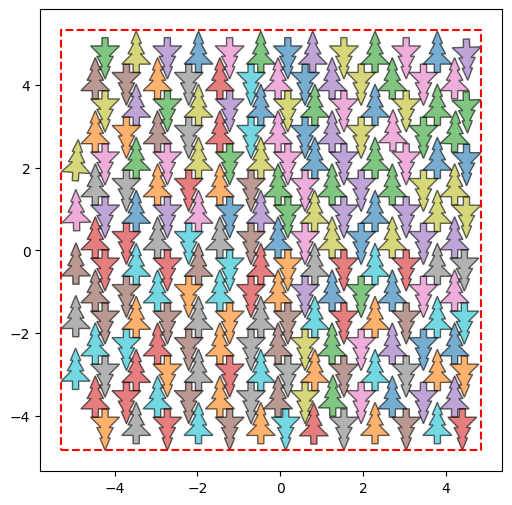

In [320]:
n_test = 200
st, meta = solve_single_n(n_test)
print(meta)
print('Overlap?', has_overlap_state(st, method='pairwise'))
print('Score_n:', score_state(st))
plot_layout_layout(state_to_layout(st))


## 15. Full Run: Solve n=1..200, Compute Total Score, Build Submission
⚠️ This can take a while depending on your environment. Start by running `max_n=50` to validate end-to-end.

After generating `submission.csv`, upload it to Kaggle.

Rationale: Use the backtest helper (below) to validate configs on smaller n-lists before a full run. This keeps runtime low while still improving the final score.


In [322]:
# Example: start small
max_n = 200
layouts, df, total = solve_all_two_pass(max_n=max_n, verbose_every=10)
df = add_rho_columns(df)
print(f"Total (1..{max_n}):", total)
print(df.sort_values("score_n", ascending=False).head(10)[["n","candidate","score_n","rho","s"]])

# Full run
#layouts, df, total = solve_all_two_pass(max_n=200, verbose_every=25)
#df = add_rho_columns(df)
#print('TOTAL (1..200):', total)
#display(df.sort_values('score_n', ascending=False).head(10))

#sub = build_submission_df(layouts)
#sub.to_csv('submission.csv', index=False)
#sub.head()



KeyboardInterrupt: 

## 16. Diagnostics & Debugging

In [35]:
# Summarize average score by bins
bins = [0, 20, 50, 100, 150, 200]
labels = ["1-20", "21-50", "51-100", "101-150", "151-200"]
df["bin"] = pd.cut(df["n"], bins=bins, labels=labels, include_lowest=True)

summary = df.groupby("bin")["score_n"].agg(["count", "mean", "sum", "max"]).reset_index()
print(summary)


       bin  count      mean        sum       max
0     1-20     20  0.630279  12.605589  0.874935
1    21-50     30  0.633070  18.992102  0.729865
2   51-100     50  0.574338  28.716886  0.684437
3  101-150     50  0.550147  27.507364  0.611956
4  151-200     50  0.542879  27.143937  0.574085


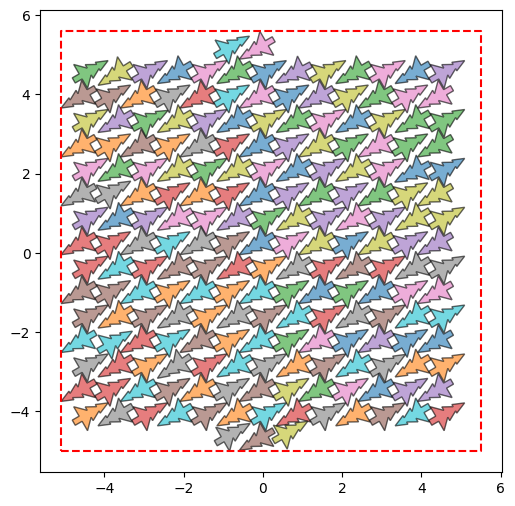

In [36]:
plot_layout_layout(layouts['200'], show_square=True)